In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import tensorflow as tf
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import preprocess

In [65]:
#List out our bandits. Currently bandit 4 
#(index 3) is set to most often provide a positive reward.

class BanditBot:
    name = 'BaseBot'
    inflation_loss = 0.995
    def __init__(self, roi=1., bankroll=1., nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        self.roi = roi
        self.bankroll = bankroll # needed to determine how much we can short
        self.p = p # our principle 
        self.q = q # amount of stock
        self.p0 = p
        self.q0 = q
        self.r_buy = r_buy # the ratio of p to spend on purchase 
        self.r_sell = r_sell # the ratio of p to liquidate on sell
        self.nt = nt # length of input vector
        
        self.p_margin = 0
        self.q_margin = 0
        
    def buy(self, x, t):
        p_spent = self.p * self.r_buy
        q_bought = p_spent / x[t]
        self.q += q_bought
        self.p -= p_spent
        return (p_spent, q_bought)
    
    def sell(self, x, t):
        q_sold = self.q * self.r_sell 
        p_earned = q_sold * x[t]
        self.q -= q_sold
        self.p += p_earned
        return (p_earned, q_sold)
    
    def short_position(self, x, t1, t2):
        q_short = self.bankroll / x[t1] # decide the amount we want to short, since in theory can short infinite
        self.q_margin += q_short
        p_earned = q_short * x[t1]
        self.p += p_earned
        
        q_return = self.q_margin
        p_buyback = q_return * x[t2]
        self.q_margin -= q_return
        self.p -= p_buyback
        return (p_earned-p_buyback, q_short)
        
        
    def liquidate(self, x):
        q_sold = self.q
        p_earned = q_sold * x[-1]
        self.q = 0
        self.p += p_earned
        return (p_earned, q_sold)
    
    def score(self, x):
        '''Liquidate all shares at current market price and then compute how much money we made'''
        self.liquidate(x)
        return float((self.roi * self.inflation_loss * self.p) - self.p0)
    
    def reset(self):
        self.p = self.p0
        self.q = self.q0
        
        
    def __call__(self, x, *args, **kwargs):
        result = np.random.randn(1)
        if result > 0:
            return 1 #return a positive reward.
        else:
            return -1 #return a negative reward.
        
class TheWimp(BanditBot):
    name = 'TheWimp'
    # Cowardly refuses to spend any money! Aka baseline
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        return self.score(x)
    
class BuyHold(BanditBot):
    name = 'BuyAndHold'
    # The classic approach - buy and hold a long position
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1., roi=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        self.roi = roi
        
    def __call__(self, x, *args, **kwargs):
        return self.score(x)
        
class TheBull(BanditBot):
    name = 'TheBull' 
        
    def __call__(self, x, *args, **kwargs):
        self.buy(x, 0)
        return self.score(x)# liquidate full position
    
class TheBear(BanditBot):
    name = 'TheBear' 
        
    def __call__(self, x, *args, **kwargs):
        self.short_position(x, 0, -1)
        return self.score(x)# liquidate full position
    
    
    
class StratBull(BanditBot):
    name = 'StratBull'
    # Check the overall progress up to the first (fraction) of the epoch. If bullish, buy in
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        t1 = nt // 3 # assess period
        if x[t1] > x[0]:
            self.buy(x, t1+1)
            
        return self.score(x) # liquidate full position
    
class StratBear(BanditBot):
    name = 'StratBear'
    # Check the overall progress up to the first (fraction) of the epoch. If bearish, short sell
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        t1 = nt // 3 # assess period
        if x[t1] < x[0]:
            self.short_position(x, t1+1, -1)
            
        return self.score(x) # liquidate full position
    
class StratTwin(BanditBot):
    name = 'StratTwin'
    # Check the overall progress up to the first (fraction) of the epoch. If bull, go long, If bearish, short sell
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        t1 = nt // 3 # assess period
        if x[t1] < x[0]:
            self.short_position(x, t1+1, -1)
        else:
            self.buy(x, t1+1)
            
        return self.score(x) # liquidate full position
    

class TheMonkey(BanditBot):
    name = 'TheMonkey'
    # A blindfolded monkey throwing darts at the newspaper's financial pages 
    def __init__(self, nt=50, p=1., q=0., r_buy=1., r_sell=1.):
        super().__init__(nt=nt, p=p, q=q, r_buy=r_buy, r_sell=r_sell)
        
    def __call__(self, x, *args, **kwargs):
        nt = len(x)
        a = np.random.randint(0, nt)
        b = np.random.randint(0, nt)
        if a > b:
            a,b = b,a
        
        self.buy(x, a)
        self.sell(x, b)    
        return self.score(x)


        
        
bandit_probs = [0.2,0,-0.2,-5]

# def pullBandit(bandit):
#     #Get a random number.
#     result = np.random.randn(1)
#     if result > bandit:
#         #return a positive reward.
#         return 1
#     else:
#         #return a negative reward.
#         return -1

0.06484872840528144


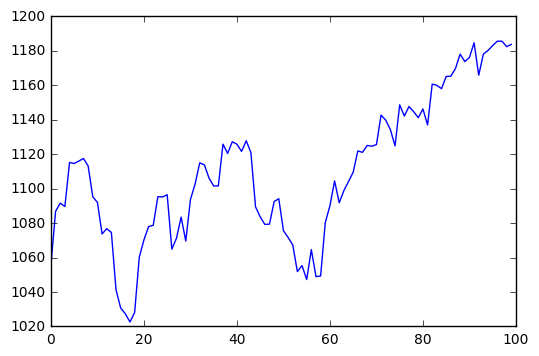

In [68]:
b = StratTwin()
y =x[::1]
print(b(y))

plt.plot(y)

In [61]:
total_episodes = 1000000 #Set total number of episodes to train agent on.
mini_epoch_size = 100
print_epoch_size = 10000


In [62]:
raw_data = pd.read_csv('data/sp500.csv', header=None)
x_train, y_train, x_test, y_test = preprocess.load_data('data/sp500.csv', mini_epoch_size, False)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3664, 100, 1) (3664,) (407, 100, 1) (407,)


In [63]:
assert mini_epoch_size < 0.5*len(x_train), 'Mini epoch size too large'

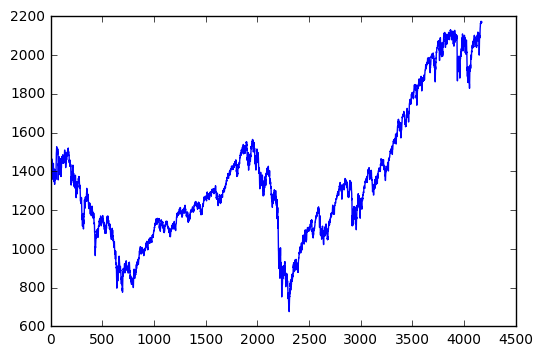

In [64]:
plt.plot(raw_data[0])

In [35]:
stock_ary = raw_data[0].values
buy_and_hold = stock_ary[-1] / stock_ary[0]
print(buy_and_hold)

1.49176078618


In [36]:
# Calc average return for basic buy and hold strategy over the long haul
avg_return = buy_and_hold** (mini_epoch_size / len(x_train))
print(avg_return)

1.01097565669


In [70]:

bots = [TheWimp(),
        BuyHold(roi=avg_return),
        TheMonkey(),
        TheBull(),
        TheBear(),
        StratBull(),
        StratBear()]

num_bandits = len(bots)

In [38]:
len(x_train) / mini_epoch_size

36.64

In [39]:
#init our agent

tf.reset_default_graph()

#These two lines established the feed-forward part of the network. 
#This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights,0)

#The next six lines establish the training proceedure. 
#We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
responsible_weight = tf.slice(weights,action_holder,[1])
loss = -(tf.log(responsible_weight)*reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

In [40]:


sample_ratio = total_episodes / mini_epoch_size
print('Mini-epoch size: {}\nNum Mini-epochs: {}'.format(mini_epoch_size, total_episodes // mini_epoch_size))
total_reward = np.zeros(num_bandits) #Set scoreboard for bandits to 0.
e = 0.2 #Set the chance of taking a random action.

init = tf.initialize_all_variables()
verbose_updates = False
# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    for i in tqdm(range(total_episodes)):
#         print('Ep {} of {}'.format(i, total_episodes))
        
        
        tp = np.random.randint(0, len(x_train))
        x = x_train[tp].ravel() # select time period
        
        #Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        
#         reward = pullBandit(bandits[action]) #Get our reward from picking one of the bandits.
        reward = bots[action](x) #Get our reward from picking one of the bandits.
        

        #Update the network.
        _,resp,ww = sess.run([update,responsible_weight,weights], feed_dict={reward_holder:[reward],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        
        if i % print_epoch_size == 0 and verbose_updates:
            print('Results: ', ' '.join(['{:.3f}'.format(bot.p) for bot in bots]))
            print("Running reward: {}".format(str(total_reward)))
        if i % mini_epoch_size == 0:
            [bot.reset() for bot in bots]
winner = np.argmax(ww)
print("The agent thinks bandit {} is the most promising....".format(bots[winner].name))


Mini-epoch size: 100
Num Mini-epochs: 1000
Instructions for updating:
Use `tf.global_variables_initializer` instead.


100%|██████████| 100000/100000 [00:53<00:00, 1863.71it/s]

The agent thinks bandit BuyIn is the most promising....


In [42]:
# print("Running reward: {}".format(str(total_reward)))
for i, bot in enumerate(bots):
    print(bot.name, total_reward[i])


TheWimp -20.275
BuyAndHold 25.1218627633
TheMonkey 31.2386500125
BuyIn 80188.9972325
StratBuyIn 107.58569115


In [ ]:
total_episodes = 1000000
print('Mini-epoch size: {}\nNum Mini-epochs: {}'.format(mini_epoch_size, total_episodes // mini_epoch_size))
total_reward = np.zeros(num_bandits) #Set scoreboard for bandits to 0.
e = 0.2 #Set the chance of taking a random action.

init = tf.initialize_all_variables()
verbose_updates = False
# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
   
    for i in tqdm(range(total_episodes)):
        tp = np.random.randint(0, len(x_train))
        x = x_train[tp].ravel() # select time period
        for action in range(len(bots)):
            reward = bots[action](x) #Get our reward from picking one of the bandits.

            #Update our running tally of scores.
            total_reward[action] += reward

        if i % print_epoch_size == 0 and verbose_updates:
            print('Results: ', ' '.join(['{:.3f}'.format(bot.p) for bot in bots]))
            print("Running reward: {}".format(str(total_reward)))
        if i % mini_epoch_size == 0:
            [bot.reset() for bot in bots]


for i, bot in enumerate(bots):
    print(bot.name, total_reward[i]/total_episodes)
    
winner = np.argmax(total_reward)
print("The agent thinks {} is the most promising....".format(bots[winner].name))

Mini-epoch size: 100
Num Mini-epochs: 10000
Instructions for updating:
Use `tf.global_variables_initializer` instead.


 10%|█         | 101597/1000000 [00:03<00:30, 29317.63it/s]